In [1]:
#! pip install -r ./requirements.txt

In [2]:
# If it's not already installed ...
# !pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [3]:
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [4]:
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-tiny", device_map="mps")

In [5]:
df = pd.read_parquet("./sales.parquet")

In [6]:
history = df.groupby("store").head(-12)
future = df.groupby("store").tail(12)

In [7]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = [torch.tensor(i) for i in history.groupby('store')['actual'].apply(list)]
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

In [8]:
low = []
median = []
high = []
for i, store in enumerate(forecast):
    p10, p50, p90 = np.quantile(forecast[i].numpy(), [0.1, 0.5, 0.9], axis=0)
    low.extend(p10)
    median.extend(p50)
    high.extend(p90)

future["p10"] = low
future["p50"] = median
future["p90"] = high

In [9]:
future

,store,week,actual,p10,p50,p90
131,1,2012-08-10,1592409.97,1.516710e+06,1.596538e+06,1.759612e+06
132,1,2012-08-17,1597868.05,1.492762e+06,1.528114e+06,1.597678e+06
133,1,2012-08-24,1494122.38,1.425479e+06,1.505306e+06,1.620486e+06
134,1,2012-08-31,1582083.40,1.477938e+06,1.573730e+06,1.655838e+06
135,1,2012-09-07,1661767.33,1.549782e+06,1.596538e+06,1.700313e+06
...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,7.412344e+05,7.771941e+05,8.746333e+05
6431,45,2012-10-05,733455.07,7.296345e+05,7.771941e+05,8.595534e+05
6432,45,2012-10-12,734464.36,7.249942e+05,7.684940e+05,8.409939e+05
6433,45,2012-10-19,718125.53,7.302145e+05,7.916942e+05,8.665137e+05


In [10]:
result = pd.concat([history, future])

In [11]:
result

,store,week,actual,p10,p50,p90
0,1,2010-02-05,1643690.90,NaN,NaN,NaN
1,1,2010-02-12,1641957.44,NaN,NaN,NaN
2,1,2010-02-19,1611968.17,NaN,NaN,NaN
3,1,2010-02-26,1409727.59,NaN,NaN,NaN
4,1,2010-03-05,1554806.68,NaN,NaN,NaN
...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,741234.44375,777194.12500,874633.27500
6431,45,2012-10-05,733455.07,729634.51250,777194.12500,859553.42500
6432,45,2012-10-12,734464.36,724994.18750,768494.00000,840993.93750
6433,45,2012-10-19,718125.53,730214.46875,791694.18750,866513.73125


In [12]:
result = result.melt(id_vars=["store", "week"], 
        var_name="type", 
        value_name="sales")

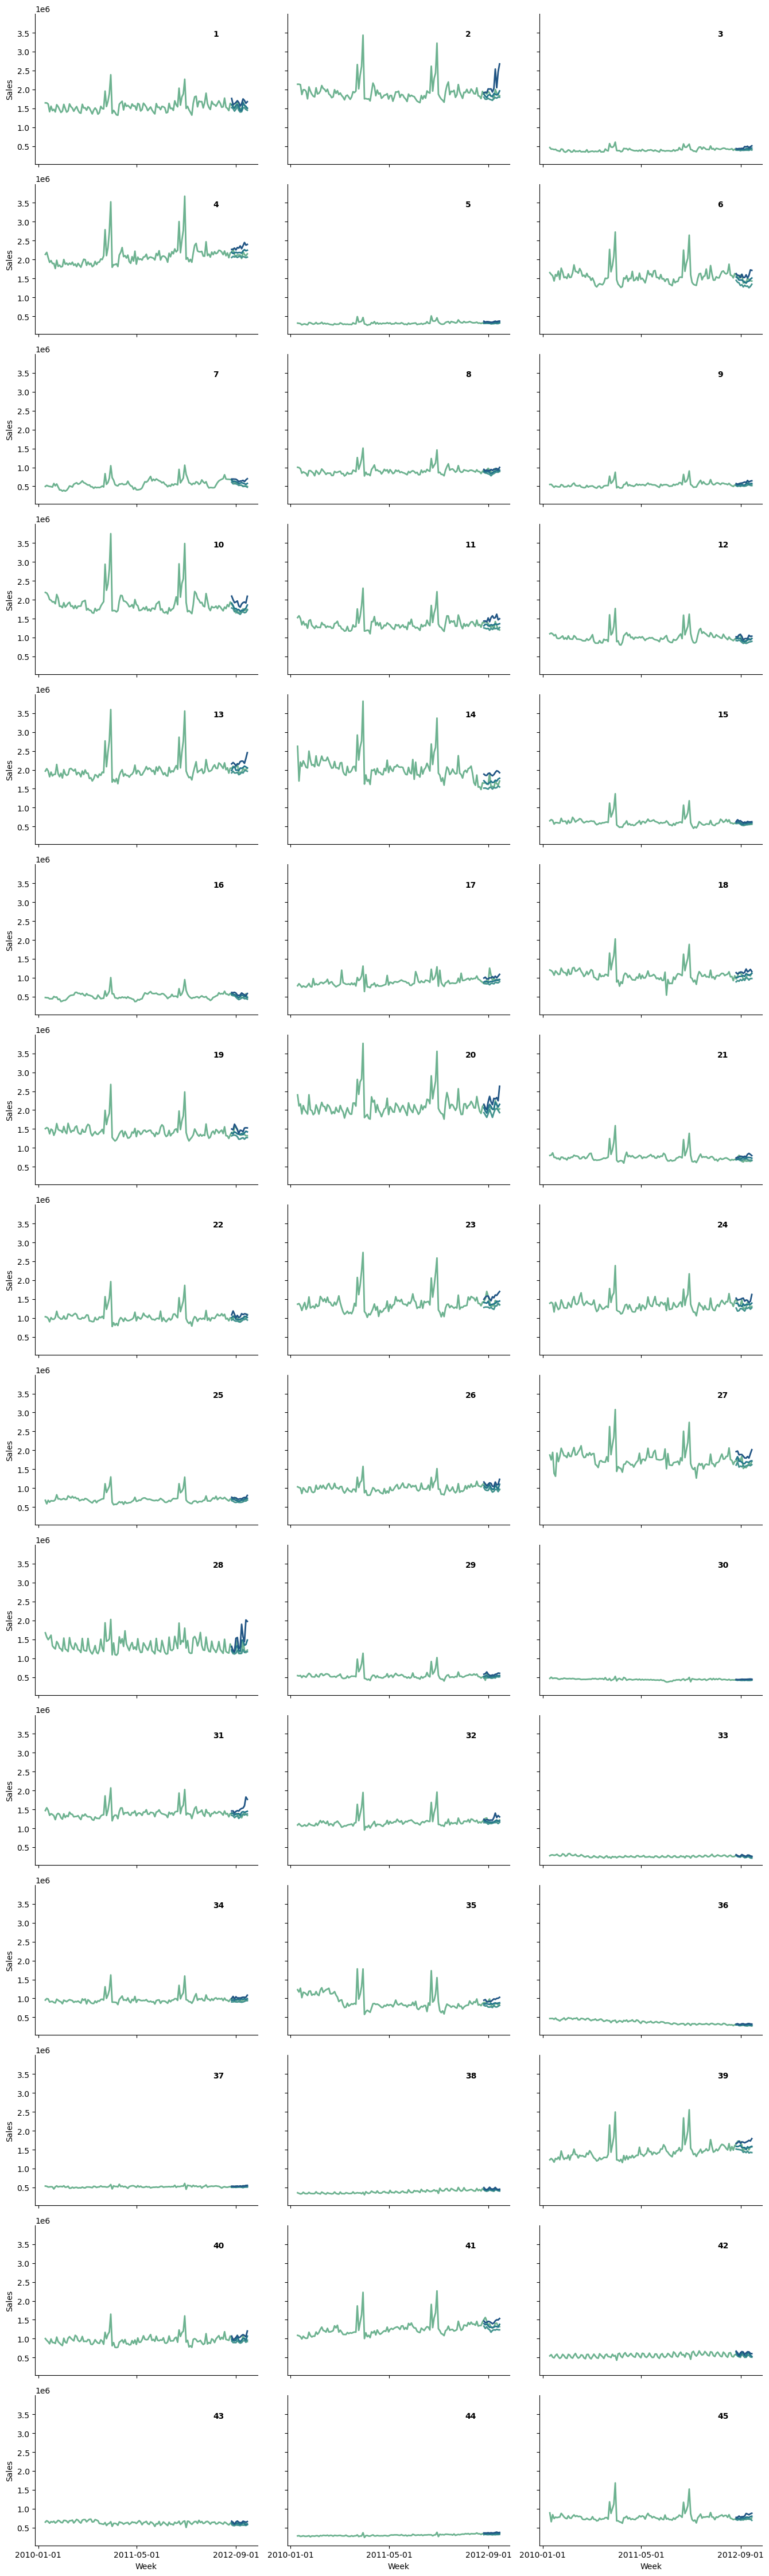

In [13]:
g = sns.relplot(
    data=result,
    x="week", y="sales", col="store", hue="type",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=3, height=3, aspect=1.5, legend=False,
)

for year, ax in g.axes_dict.items():
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

ax.set_xticks(ax.get_xticks()[::4])
g.set_titles("")
g.set_axis_labels("Week", "Sales")
g.tight_layout()